In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/siyuyang/Source/Repos/GitHub_MSFT/CameraTraps')

In [247]:
import json
import os
from collections import defaultdict
from random import sample

import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from azure.storage.blob import BlobServiceClient
from PIL import Image

# requires the TF Object Detection API be installed
from detection.detector_eval import detector_eval  # detector_eval.py functions in this directory
from visualization import visualization_utils as viz_utils

# MegaDetector v4 experiments - evaluation

For MDv2 results, some locations in its training set are in this test set (MDv4 test set).

In [4]:
mdv4boxes_label_path = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/Databases/query_results/bboxes_20200123.json'

res_dir = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/MegaDetectorEval/megadetectorv4/mdv4_results'
test_set_res_paths = {
    'No transfer learning': '6851_detections_mdv4_nococo_run4_step840k_on_test_20200322221838.json',
    'No transfer learning with hard negatives': '3438_detections_mdv4_nococo_run5_step1040k_on_test_20200322221923.json',
    'Hard negatives from 1.5 epoch with augmentation': '9048_detections_mdv4_hardneg_run4_step1260k_on_test_20200322221759.json',
    'Hard negatives from 2.5 epoch': '9158_detections_mdv4_hardneg_run3_step960k_on_test_20200322221633.json',
    'Hard negatives from 1.5 epoch': '3998_detections_mdv4_hardneg_run2_step1080k_on_test_20200322221449.json',
    'Hard negatives from start': '1838_detections_mdv4_hardneg_run1_step1010k_on_test_20200322221339.json',
    
    'Augmentation - orientation': '3858_detections_mdv4_aug_run5_step820k_on_test_20200313071922.json',
    'Augmentation - orientation and color': '8411_detections_mdv4_aug_run4_step1160k_on_test_20200313071808.json',
    'MDv4 baseline': '5247_detections_mdv4_baseline_run12_step520k_on_test_20200310001011.json',
    'MDv4 baseline preliminary': '8542_detections_mdv4_baseline_run5_step735902_on_test_20200310014304.json',
    'MDv3': '8583_detections_mdv3_on_test_20200310002010.json',
    'MDv2': '1983_detections_mdv2_on_test_20200310004514.json'
}


out_dir = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/MegaDetectorEval/megadetectorv4'

## Matching label and predicted boxes

In [5]:
test_set_res = {}
for checkpoint_name, out_name in test_set_res_paths.items():
    with open(os.path.join(res_dir, out_name)) as f:
        test_set_res[checkpoint_name] = json.load(f)['images']
    print('{}, number of results: {}'.format(checkpoint_name, len(test_set_res[checkpoint_name])))

No transfer learning, number of results: 17023
No transfer learning with hard negatives, number of results: 17023
Hard negatives from 1.5 epoch with augmentation, number of results: 17023
Hard negatives from 2.5 epoch, number of results: 17023
Hard negatives from 1.5 epoch, number of results: 17023
Hard negatives from start, number of results: 17023
Augmentation - orientation, number of results: 17023
Augmentation - orientation and color, number of results: 17023
MDv4 baseline, number of results: 17023
MDv4 baseline preliminary, number of results: 17023
MDv3, number of results: 17023
MDv2, number of results: 17023


In [6]:
# for numerical IDs from output files of the API, and names in the MegaDB
label_map_name_to_id = {
    'animal': 1,
    'person': 2,
    'vehicle': 3
}

In [8]:
test_set_res['MDv4 baseline'][100]

{'file': 'mdv4_images/test/rspb_gola+899c8a74-3f14-11ea-b66d-9801a7a664ab.jpg',
 'max_detection_conf': 1.0,
 'detections': [{'category': '1',
   'conf': 1.0,
   'bbox': [0.0016, 0.2824, 0.2653, 0.3398]},
  {'category': '1', 'conf': 0.068, 'bbox': [0.9802, 0.4392, 0.0177, 0.0373]},
  {'category': '1', 'conf': 0.064, 'bbox': [0.9764, 0.4356, 0.0225, 0.0582]}]}

In [10]:
# not used

test_set = set([i['file'].split('/')[-1].split('.jpg')[0] for i in test_set_res['MDv4 baseline']])
len(test_set)

17023

In [11]:
with open(mdv4boxes_label_path) as f:
    mdv4boxes_labels = json.load(f)

In [12]:
len(mdv4boxes_labels)
mdv4boxes_labels[100]

480000

{'bbox': [{'category': 'person', 'bbox': [0.7821, 0.6417, 0.2178, 0.3316]},
  {'category': 'person', 'bbox': [0, 0.2614, 0.2018, 0.29]}],
 'file': 'Day/2/IMAG0462 (7).JPG',
 'dataset': 'peaceparks_201908_humans',
 'location': '7',
 'download_id': 'peaceparks_201908_humans+8896d576-3f14-11ea-b3bb-9801a7a664ab'}

In [13]:
mdv4boxes_labels_dict = {}
for i in mdv4boxes_labels:
    if i['download_id'] in test_set:
        mdv4boxes_labels_dict[i['download_id']] = i
print(len(mdv4boxes_labels_dict))

17023


In [231]:
mdv4boxes_labels_dict['zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab']

{'bbox': [{'category': 'animal', 'bbox': [0.02823, 0.2205, 0.02278, 0.08518]}],
 'file': 'Maliau/Maliau_3/OG1-E-38/20120416-005602(2)10 of 10.jpg',
 'dataset': 'zsl_borneo',
 'location': 'OG1-E-38',
 'download_id': 'zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab'}

## Compute metrics

In [ ]:
checkpoint_metrics = {}

for checkpoint_name, detection_res in test_set_res.items():
    print(checkpoint_name)
    
    per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(
        mdv4boxes_labels_dict, detection_res, label_map_name_to_id)
        
    print('Lengths of per_image_gts is {}, per_image_detections is {}'.format(
        len(per_image_gts), len(per_image_detections)))
    
    per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, 3, 
                                                    matching_iou_threshold=0.5)

    checkpoint_metrics[checkpoint_name] = per_cat_metrics
    print('one_class average precision is {}'.format(per_cat_metrics['one_class']['average_precision']))
    print('-----------')
    

## Plot precision-recall

In [15]:
categories = {
    1: 'animal',
    2: 'person',
    3: 'vehicle',
    'one_class': 'one class'
}

In [16]:
for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():            
    print(checkpoint_name)
    average_precision_category = []
    for cat in categories:
        print(cat)
        ave_prec = per_cat_metrics[cat]['average_precision']
        print(ave_prec)
        if cat in [1, 2, 3] and ave_prec > 0:
            average_precision_category.append(ave_prec)
    
    mAP = sum(average_precision_category) / len(average_precision_category)
    print('mAP is {}'.format(mAP))
    print('-----------')

No transfer learning
1
0.8110217679949923
2
0.8262919828964835
3
0.5980134194869301
one_class
0.8121055770258437
mAP is 0.7451090567928019
-----------
No transfer learning with hard negatives
1
0.8091978895099936
2
0.8243396988517779
3
0.5274949685649053
one_class
0.8107566696346687
mAP is 0.7203441856422256
-----------
Hard negatives from 1.5 epoch with augmentation
1
0.8808927484628778
2
0.9360019026177049
3
0.8883341651863497
one_class
0.8889560714511969
mAP is 0.901742938755644
-----------
Hard negatives from 2.5 epoch
1
0.8794483812775885
2
0.9356224318002138
3
0.8859221391356166
one_class
0.8874816862694309
mAP is 0.9003309840711397
-----------
Hard negatives from 1.5 epoch
1
0.8678408870894192
2
0.9320881440231196
3
0.8851765609178232
one_class
0.8769869000245691
mAP is 0.895035197343454
-----------
Hard negatives from start
1
0.8712561259885554
2
0.9268215382608769
3
0.8788040908428499
one_class
0.8792641846323521
mAP is 0.8922939183640941
-----------
Augmentation - orientation

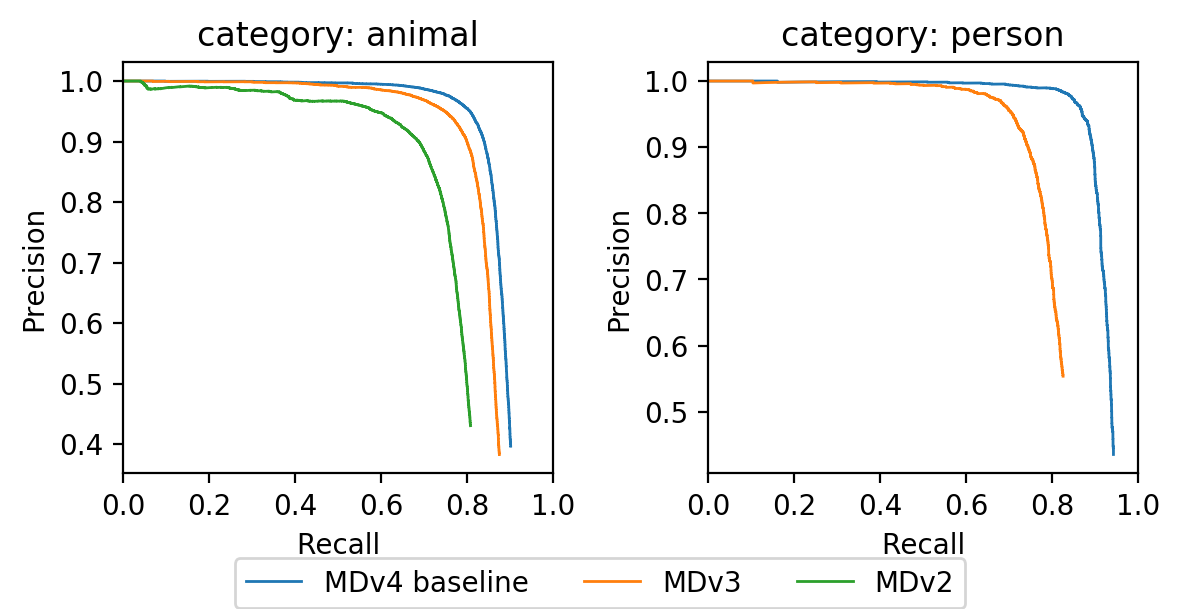

In [107]:
runs_to_show = ['MDv4 baseline', 'MDv3', 'MDv2']

# Create two subplots sharing x axis
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3), dpi=200, tight_layout=True)

for cat, cat_label, ax in zip([1, 2], ['animal', 'person'], [ax1, ax2]):
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        if checkpoint_name not in ['MDv4 baseline', 'MDv3', 'MDv2']:
            continue
            
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=1)  
        _, _ = ax.set_xlim(left=0.0, right=1.0)
        

        _ = ax.set_xlabel('Recall')
        _ = ax.set_ylabel('Precision')
        _ = ax.set_title('category: ' + cat_label)

lines, labels = fig.axes[-1].get_legend_handles_labels()
_ = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.108), ncol=3)

In [ ]:
runs_to_show = ['Augmentation - orientation', 'Augmentation - orientation and color',
               'Hard negatives from start', 'Hard negatives from 1.5 epoch', 
                'Hard negatives from 2.5 epoch', 'Hard negatives from 1.5 epoch with augmentation',
               'MDv4 baseline']


fig = plt.figure(figsize=(5, 6), dpi=200)

for cat, cat_label in zip([1, 2, 3], ['animal', 'person', 'vehicle']):
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        if checkpoint_name not in runs_to_show:
            continue
            
        bbox = [0.1, -0.4 * cat, 0.5, 0.3]
        ax = fig.add_axes(bbox)
            
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=0.5)  
        _, _ = ax.set_xlim(left=0.0, right=1.0)
        _, _ = ax.set_ylim(bottom=0.0, top=1.0)
        
        if cat == 3:
            _ = ax.set_xlabel('Recall')
                        
        _ = ax.set_ylabel('Precision')
        _ = ax.set_title('category: ' + cat_label)

lines, labels = fig.axes[-1].get_legend_handles_labels()
_ = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.35, 1.5), fontsize='small')

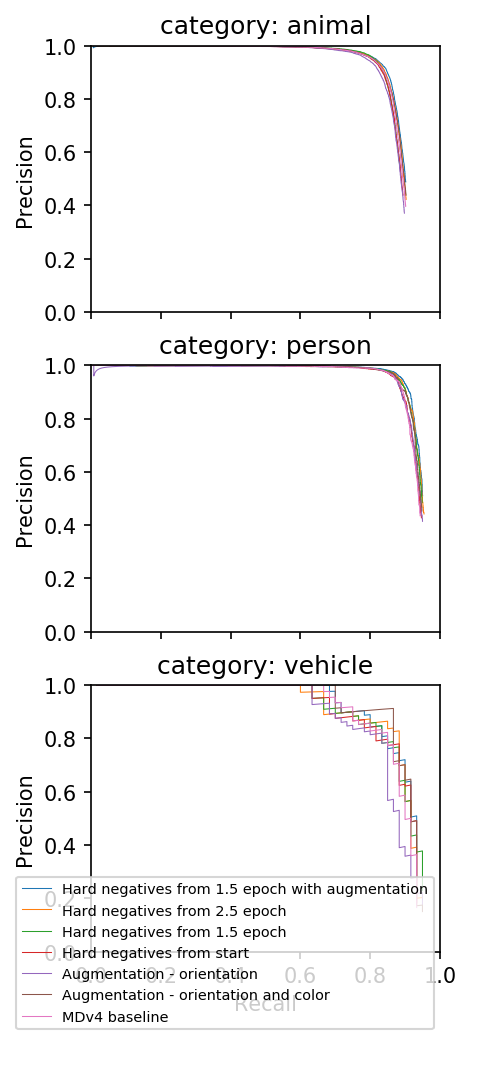

In [197]:
runs_to_show = ['Augmentation - orientation', 'Augmentation - orientation and color',
               'Hard negatives from start', 'Hard negatives from 1.5 epoch', 
                'Hard negatives from 2.5 epoch', 'Hard negatives from 1.5 epoch with augmentation',
               'MDv4 baseline']


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(3, 8), dpi=150)


for cat, cat_label, ax in zip([1, 2, 3], ['animal', 'person', 'vehicle'], [ax1, ax2, ax3]):
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        if checkpoint_name not in runs_to_show:
            continue
            
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=0.5)  
        _, _ = ax.set_xlim(left=0.0, right=1.0)
        _, _ = ax.set_ylim(bottom=0.0, top=1.0)
        
        if cat == 3:
            _ = ax.set_xlabel('Recall')
            
        _ = ax.set_ylabel('Precision')
        _ = ax.set_title('category: ' + cat_label)

lines, labels = fig.axes[-1].get_legend_handles_labels()
_ = fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, 0.1), fontsize='x-small')

In [109]:
cat_to_fig = {}
for cat, cat_label in categories.items():
    fig = matplotlib.figure.Figure(figsize=(3, 3), dpi=150)
    ax = fig.add_axes((0, 0, 1, 1))
    
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        if checkpoint_name not in runs_to_show:
            continue
        
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=1)  
    
    _ = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=False, ncol=2)
    _, _ = ax.set_xlim(left=0.0, right=1.0)
    
    _ = ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')
    _ = ax.set_title('category: ' + cat_label)
    
    cat_to_fig[cat] = fig

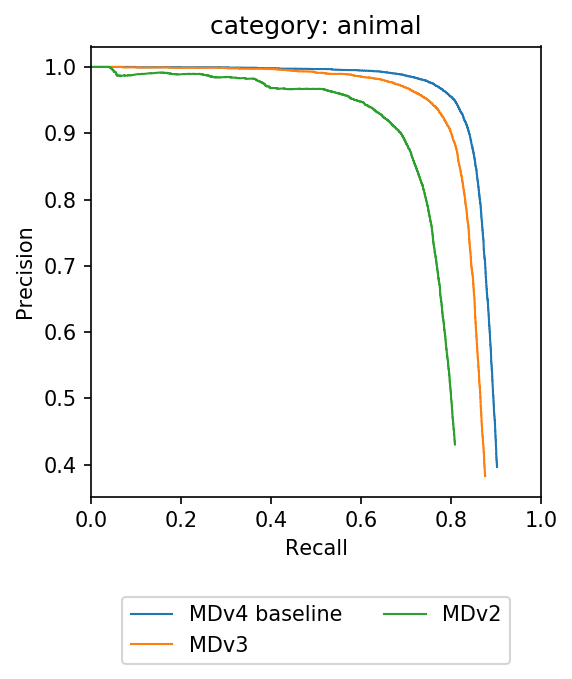

In [28]:
cat_to_fig[1]
cat_to_fig[1].savefig('/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/Docs/MDv4_MSJAR/visuals/prec_recall_baseline_animal.png')

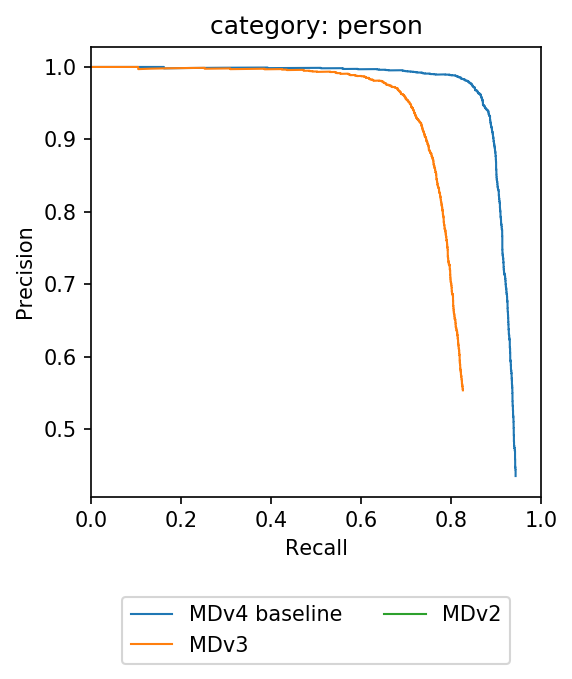

In [29]:
cat_to_fig[2]
cat_to_fig[2].savefig('/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/Docs/MDv4_MSJAR/visuals/prec_recall_baseline_person.png')

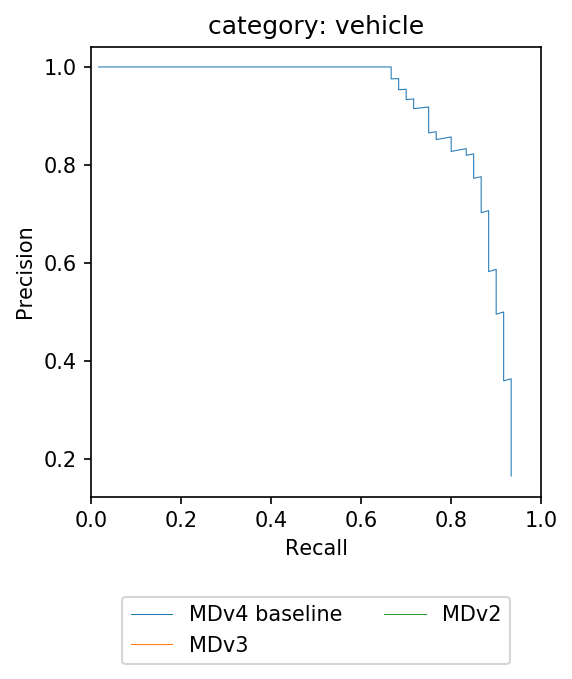

In [20]:
cat_to_fig[3]

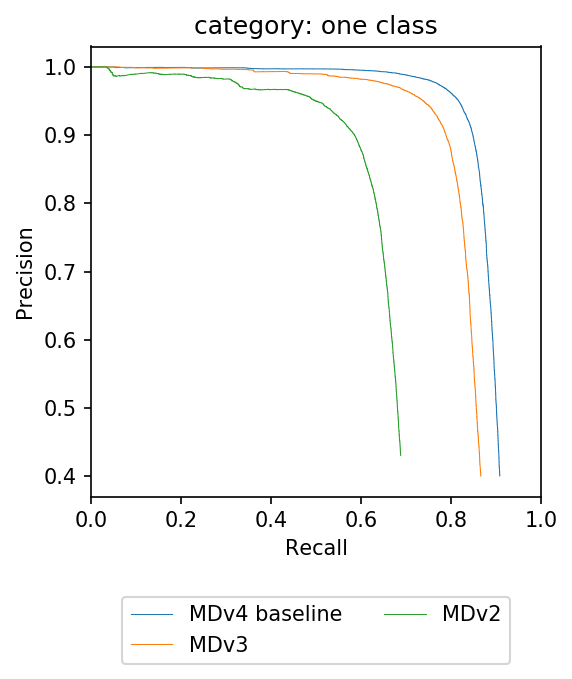

In [21]:
cat_to_fig['one_class']

## Number of true and false positives

In [ ]:
for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
    
    if checkpoint_name not in runs_to_show:
        continue
    
    print('\n{}'.format(checkpoint_name))
    for category, metrics in per_cat_metrics.items():
        print('category: {}'.format(category))
        for score_threshold in [0.5, 0.8, 0.9, 0.97]:
            total_tp = 0
            total_fp = 0
            for score, tp_fp in zip(metrics['scores'], metrics['tp_fp']):
                if score > score_threshold:
                    if tp_fp == 1:
                        total_tp += 1
                    else:
                        total_fp += 1
                        
            ratio = total_tp/total_fp if total_fp > 0 else None
            print('    score_threshold: {}, tp: {}, fp: {}, tp:fp ratio: {}'.format(
                score_threshold, total_tp, total_fp, ratio))

## Visualize some results

In [219]:
test_im_dir = '/Users/siyuyang/Source/temp_data/CameraTrap/samples/mdv4_test'

In [202]:
runs_to_compare = ['MDv4 baseline', 'Augmentation - orientation and color']

results_to_compare = {}

test_set_files = set()

for run_name in runs_to_compare:
    res = test_set_res[run_name]
    im_id_to_res = {}
    for r in res:
        download_id = r['file'].split('/')[-1].split('.jpg')[0]
        test_set_files.add(download_id)
        im_id_to_res[download_id] = r
    results_to_compare[run_name] = im_id_to_res

In [241]:
diff_threshold = 0.6

very_diff_entries = []

for download_id in test_set_files:
    conf_scores = []
    for run_name in runs_to_compare:
        conf_scores.append(results_to_compare[run_name][download_id]['max_detection_conf'])
    
    if max(conf_scores) - min(conf_scores) > diff_threshold:
        very_diff_entries.append(download_id)
        
len(very_diff_entries)

44

In [215]:
sas_token = os.environ['SAS_TOKEN']

In [216]:
blob_service = BlobServiceClient(
    account_url='cameratrapsc.blob.core.windows.net',
    credential=sas_token)

In [252]:
samples = sample(test_set_files, 40)

In [253]:
test_im_dir = '/Users/siyuyang/Source/temp_data/CameraTrap/samples/mdv4_test_samples_2'

container_client = blob_service.get_container_client('megadetectorv4-artifacts')
for i in samples:
    if not os.path.exists(os.path.join(test_im_dir, '{}.jpg'.format(i))):
        with open(os.path.join(test_im_dir, '{}.jpg'.format(i)), 'wb') as f:
            container_client.download_blob('mdv4_images/test/' + i + '.jpg').readinto(f)

In [222]:
label_map = {
    '1': 'animal',
    '2': 'person',
    '3': 'vehicle'  # will be available in megadetector v4
}

In [ ]:
confidence_threshold = 0.5

for download_id in samples:
    print('\n{}'.format(download_id))
    
    print('ground truth')
    image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, '{}.jpg'.format(download_id))), 600)
    gt_bbox = mdv4boxes_labels_dict[download_id]['bbox']    
    viz_utils.render_megadb_bounding_boxes(gt_bbox, image)
    image
    
    for run_name in runs_to_compare:
        print(run_name, results_to_compare[run_name][download_id]['max_detection_conf'])
        detections = results_to_compare[run_name][download_id]['detections']
        
        # need to reload the image for each rendering
        image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, '{}.jpg'.format(download_id))), 600)

        viz_utils.DetectorUtils.render_detection_bounding_boxes(detections, image, label_map=label_map,
                                              confidence_threshold=confidence_threshold)
        image